In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.stats import false_discovery_control

In [2]:
nas_dir = "/home/jaejoong/cocoanlab02"
dat_dir = os.path.join(nas_dir, "projects/AIDA/dataset")
result_dir = os.path.join(nas_dir, "projects/AIDA/results")

In [3]:
all_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_df.csv"))
all_resp_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_resp_df.csv"))

In [4]:
prev_mae = {"Test 1": {"Rosenman2024": 3.46,
                       "Agarwal2024": 3.52,
                       "Milintsevich2024": 3.59,
                       "Milintsevich2023": 3.78,
                       "Lau2023": 3.80},
            "Test 2 E-DAIC": {"Sadeghi2024": 3.86,
                              "Ray2019": 4.02,
                              "Sadeghi2023": 4.26}}
Q_desc = ["Q1: Anhedonia", # Diminished interest or pleasure
          "Q2: Depressed mood",
          "Q3: Sleep disturbance", # Insomnia or hypersomnia
          "Q4: Fatigue", # Fatigue or loss of energy
          "Q5: Appetite disturbance", # Poor appetite or overeating
          "Q6: Worthlessness", # Feelings of worthlessness or guilt
          "Q7: Poor concentration", # Diminished ability to think or concentrate
          "Q8: Psychomotor disturbance", # Psychomotor agitation or retardation
          "Q9: Positive sentiment",
          "Q10: Negative sentiment",
          "Q11: Self-focused language",
          "Q12: Present-focused language",
          "Q13: Emotion differentiation",
          "Q14: Mindreading",
          "Q15: Catastrophizing",
          "Q16: All-or-nothing thinking",
          "Q17: Emotional reasoning",
          "Q18: Labeling",
          "Q19: Mental filter",
          "Q20: Overgeneralization",
          "Q21: Personalization",
          "Q22: Should statements",
          "Q23: Disqualifying the positive"] # Minimizing or disqualifying the positive

In [5]:
def linreg_scaled(X, Y, wh_tr):

    scaler = StandardScaler()
    scaler.fit_transform(X[wh_tr, :])
    X_scaled = scaler.transform(X)
    
    model = LinearRegression()
    model.fit(X_scaled[wh_tr, :], Y[wh_tr])
    Y_pred = model.predict(X_scaled)

    return scaler, model, Y_pred

def linreg_metrics(Y, Y_pred):
    
    mae = mean_absolute_error(Y, Y_pred)
    rmse = root_mean_squared_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    metrics = {"mae": mae, "rmse": rmse, "r2": r2}

    return metrics

In [6]:
all_mdl = {"Full": {"Q": range(0,23), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "PHQ8": {"Q": range(0,8), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "Ling": {"Q": range(8,13), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "CDS": {"Q": range(13,23), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "NonD": {"Q": range(23,33), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "Dir": {"Q": range(33,34), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}}}

for mdl in all_mdl:
    
    X = np.array(all_resp_df.iloc[:, all_mdl[mdl]["Q"]])
    Y = np.array(all_df["Depression_severity"])
    wh_tr = np.array(all_df["split"] == "Training")
    
    all_mdl[mdl]["scaler"], all_mdl[mdl]["model"], all_mdl[mdl]["Y_pred"] = linreg_scaled(X, Y, wh_tr)
    for split in ["Training", "Test 1", "Test 2", "Test 2 E-DAIC"]:
        wh_split = all_df["split_edaic" if split == "Test 2 E-DAIC" else "split"] == split
        all_mdl[mdl]["metrics"][split] = linreg_metrics(Y[wh_split], all_mdl[mdl]["Y_pred"][wh_split])

In [7]:
joblib.dump(all_mdl, os.path.join(result_dir, "all_mdl.joblib"))

['/home/jaejoong/cocoanlab02/projects/AIDA/results/all_mdl.joblib']

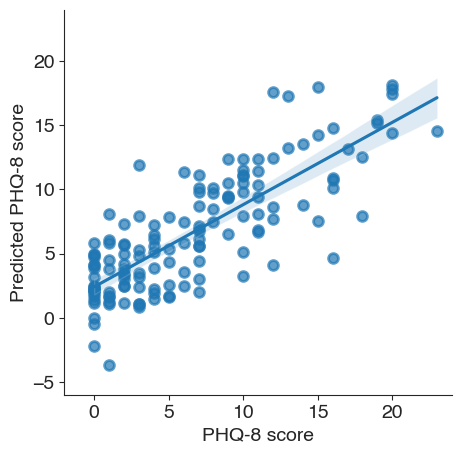

Training: MAE = 2.70, RMSE = 3.46, R2 = 0.64


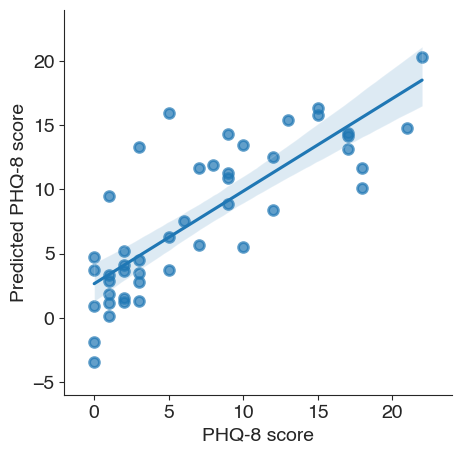

Test 1: MAE = 2.91, RMSE = 3.88, R2 = 0.63


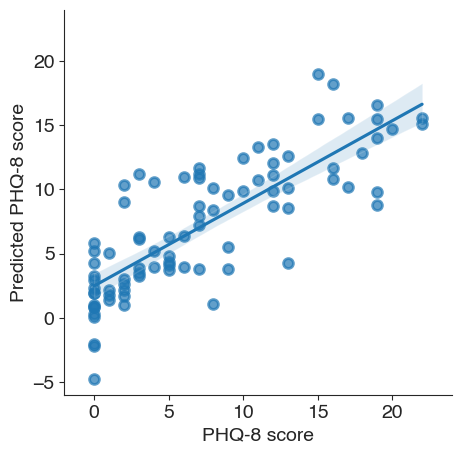

Test 2: MAE = 2.86, RMSE = 3.79, R2 = 0.66


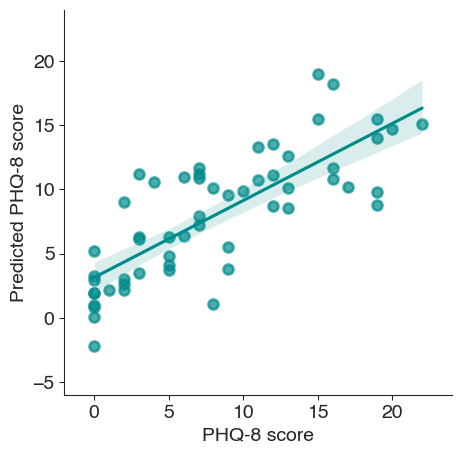

Test 2 E-DAIC: MAE = 3.07, RMSE = 3.97, R2 = 0.61


In [8]:
for split in ["Training", "Test 1", "Test 2", "Test 2 E-DAIC"]:
    wh_split = all_df["split_edaic" if split == "Test 2 E-DAIC" else "split"] == split
    x = all_df["Depression_severity"][wh_split]
    y = all_mdl["Full"]["Y_pred"][wh_split]
    
    plt.figure(figsize=(5, 5))
    sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
    sns.scatterplot(x=x, y=y, s=50, alpha=0.7, legend=False, color="darkcyan" if split == "Test 2 E-DAIC" else "#1F77B4", edgecolors="Face", linewidths=2)
    sns.regplot(x=x, y=y, scatter=False, seed=42, color="darkcyan" if split == "Test 2 E-DAIC" else "#1F77B4")
    sns.despine()
    plt.xlim([-2, 24])
    plt.ylim([-6, 24])
    plt.xlabel("PHQ-8 score", fontsize=14)
    plt.ylabel("Predicted PHQ-8 score", fontsize=14)
    plt.xticks(range(0, 25, 5), fontsize=14)
    plt.yticks(range(-5, 25, 5), fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_PHQ-8_vs_Predicted_PHQ-8_{split.replace(" ", "_")}.pdf"), bbox_inches='tight')
    plt.show()
    print(f"{split}: MAE = {all_mdl["Full"]["metrics"][split]["mae"]:.2f}, RMSE = {all_mdl["Full"]["metrics"][split]["rmse"]:.2f}, R2 = {all_mdl["Full"]["metrics"][split]["r2"]:.2f}")

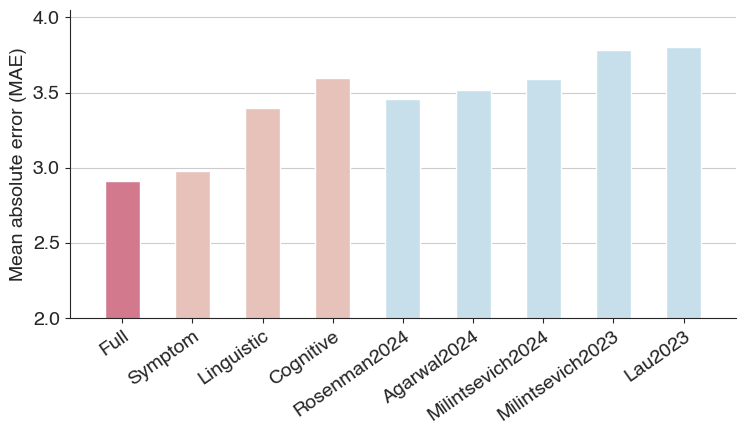

Test 1: MAE = ['Full: 2.91', 'Symptom: 2.97', 'Linguistic: 3.40', 'Cognitive: 3.60', 'Rosenman2024: 3.46', 'Agarwal2024: 3.52', 'Milintsevich2024: 3.59', 'Milintsevich2023: 3.78', 'Lau2023: 3.80']


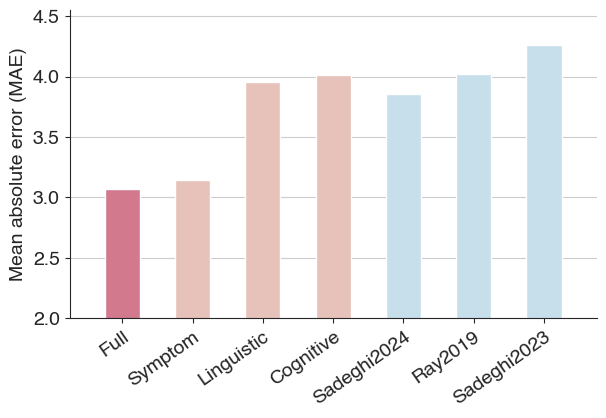

Test 2 E-DAIC: MAE = ['Full: 3.07', 'Symptom: 3.14', 'Linguistic: 3.96', 'Cognitive: 4.01', 'Sadeghi2024: 3.86', 'Ray2019: 4.02', 'Sadeghi2023: 4.26']


In [9]:
for split in ["Test 1", "Test 2 E-DAIC"]:
    x = ["Full", "Symptom", "Linguistic", "Cognitive"] + list(prev_mae[split].keys())
    y = [all_mdl[mdl]["metrics"][split]["mae"] for mdl in ["Full", "PHQ8", "Ling", "CDS"]] + list(prev_mae[split].values())
    g = [0] + [1]*3 + [2]*len(prev_mae[split])
    
    plt.figure(figsize=(len(g)*0.9+0.5, 4))
    sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
    sns.barplot(x=x, y=y, hue=g, width=0.5, palette=["#E16A86", "#EEBDB2", "#C1E1F1"], legend=False)
    sns.despine()
    plt.grid(True, axis='y')
    plt.xlim([-0.75, len(x)-0.25])
    plt.ylim([2, 4.05] if split == "Test 1" else [2, 4.55])
    plt.ylabel("Mean absolute error (MAE)", fontsize=14)
    plt.xticks(np.arange(len(g)), rotation=35, rotation_mode="anchor", ha="right", va="top", fontsize=14)
    plt.yticks(np.arange(2, 4.5 if split == "Test 1" else 5, 0.5), fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_MAE_{split.replace(" ", "_")}.pdf"), bbox_inches='tight')
    plt.show()
    print(f"{split}: MAE = {[f'{x_each}: {y_each:.2f}' for x_each, y_each in zip(x,y)]}")

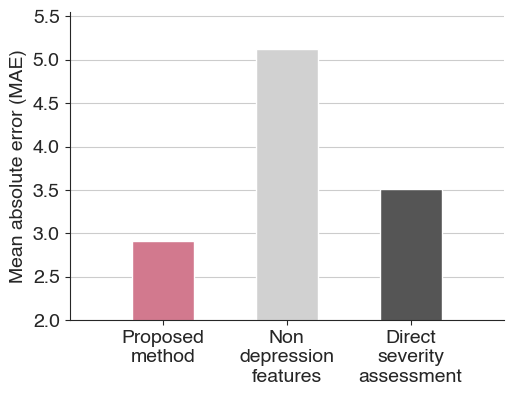

Test 1: MAE = ['Proposed\nmethod: 2.91', 'Non\ndepression\nfeatures: 5.12', 'Direct\nseverity\nassessment: 3.51']


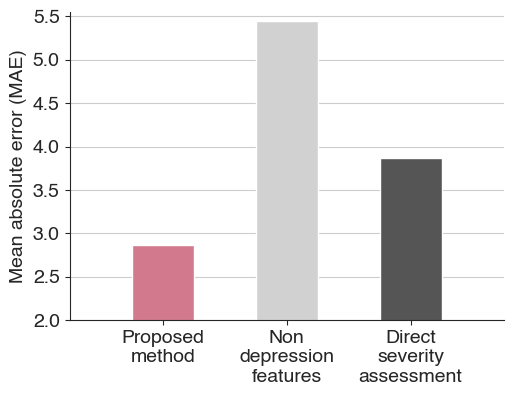

Test 2: MAE = ['Proposed\nmethod: 2.86', 'Non\ndepression\nfeatures: 5.45', 'Direct\nseverity\nassessment: 3.87']


In [10]:
for split in ["Test 1", "Test 2"]:
    x = ["Proposed\nmethod", "Non\ndepression\nfeatures", "Direct\nseverity\nassessment"]
    y = [all_mdl[mdl]["metrics"][split]["mae"] for mdl in ["Full", "NonD", "Dir"]]
    g = [0] + [1]*1 + [2]*1
    
    plt.figure(figsize=(len(g)*1.7+0.5, 4))
    sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
    sns.barplot(x=x, y=y, hue=g, width=0.5, palette=["#E16A86", "#D1D1D1", "#555555"], legend=False)
    sns.despine()
    plt.grid(True, axis='y')
    plt.xlim([-0.75, len(x)-0.25])
    plt.ylim([2, 5.55])
    plt.ylabel("Mean absolute error (MAE)", fontsize=14)
    plt.xticks(np.arange(len(g)), fontsize=14)
    plt.yticks(np.arange(2, 6.0 if split == "Test 1" else 6.0, 0.5), fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_MAE_alt_{split.replace(" ", "_")}.pdf"), bbox_inches='tight')
    plt.show()
    print(f"{split}: MAE = {[f'{x_each}: {y_each:.2f}' for x_each, y_each in zip(x,y)]}")

/opt/conda/envs/jj-daicwoz/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/envs/jj-daicwoz/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


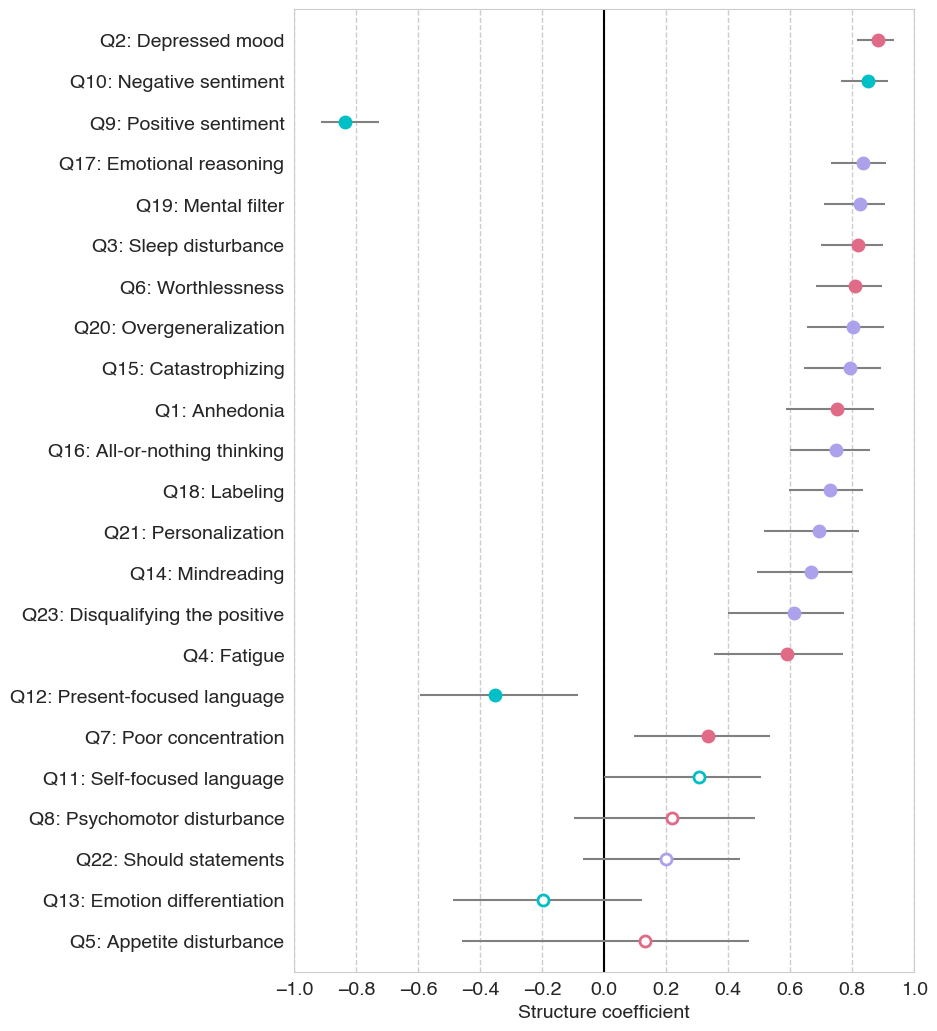

Test 1:

Q2: Depressed mood; r = 0.88, 95% CI = 0.81 to 0.93, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q10: Negative sentiment; r = 0.85, 95% CI = 0.77 to 0.91, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q9: Positive sentiment; r = -0.84, 95% CI = -0.91 to -0.72, p-val = 2.0E-04 (0.0002), FDR p-val = 2.9E-04 (0.0003)
Q17: Emotional reasoning; r = 0.83, 95% CI = 0.73 to 0.91, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q19: Mental filter; r = 0.83, 95% CI = 0.71 to 0.91, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q3: Sleep disturbance; r = 0.82, 95% CI = 0.70 to 0.90, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q6: Worthlessness; r = 0.81, 95% CI = 0.68 to 0.90, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q20: Overgeneralization; r = 0.80, 95% CI = 0.65 to 0.90, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q15: Catastrophizing; r = 0.79, 95% CI = 0.65 to 0.89, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (

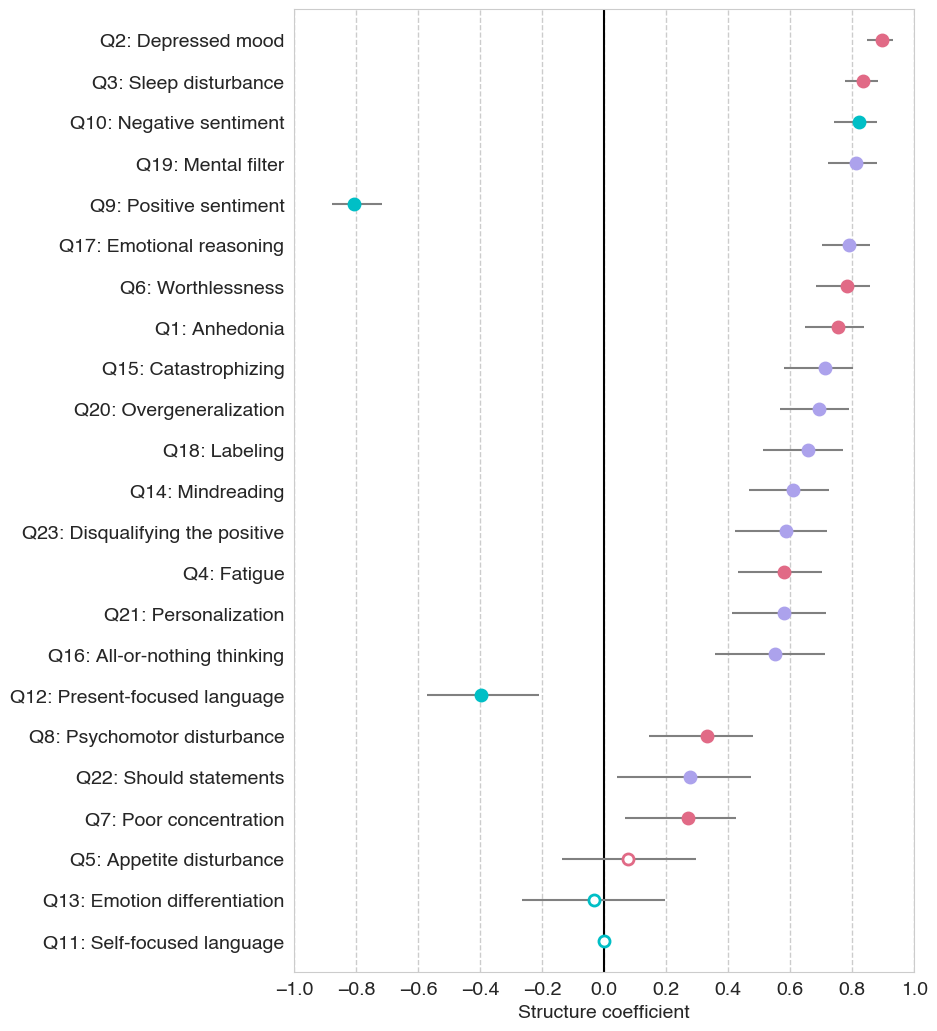

Test 2:

Q2: Depressed mood; r = 0.89, 95% CI = 0.85 to 0.93, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q3: Sleep disturbance; r = 0.83, 95% CI = 0.78 to 0.88, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q10: Negative sentiment; r = 0.82, 95% CI = 0.74 to 0.88, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q19: Mental filter; r = 0.81, 95% CI = 0.72 to 0.88, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q9: Positive sentiment; r = -0.81, 95% CI = -0.88 to -0.72, p-val = 2.0E-04 (0.0002), FDR p-val = 2.9E-04 (0.0003)
Q17: Emotional reasoning; r = 0.79, 95% CI = 0.70 to 0.86, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q6: Worthlessness; r = 0.78, 95% CI = 0.68 to 0.86, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q1: Anhedonia; r = 0.75, 95% CI = 0.65 to 0.84, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q15: Catastrophizing; r = 0.71, 95% CI = 0.58 to 0.80, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q2

/opt/conda/envs/jj-daicwoz/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/envs/jj-daicwoz/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


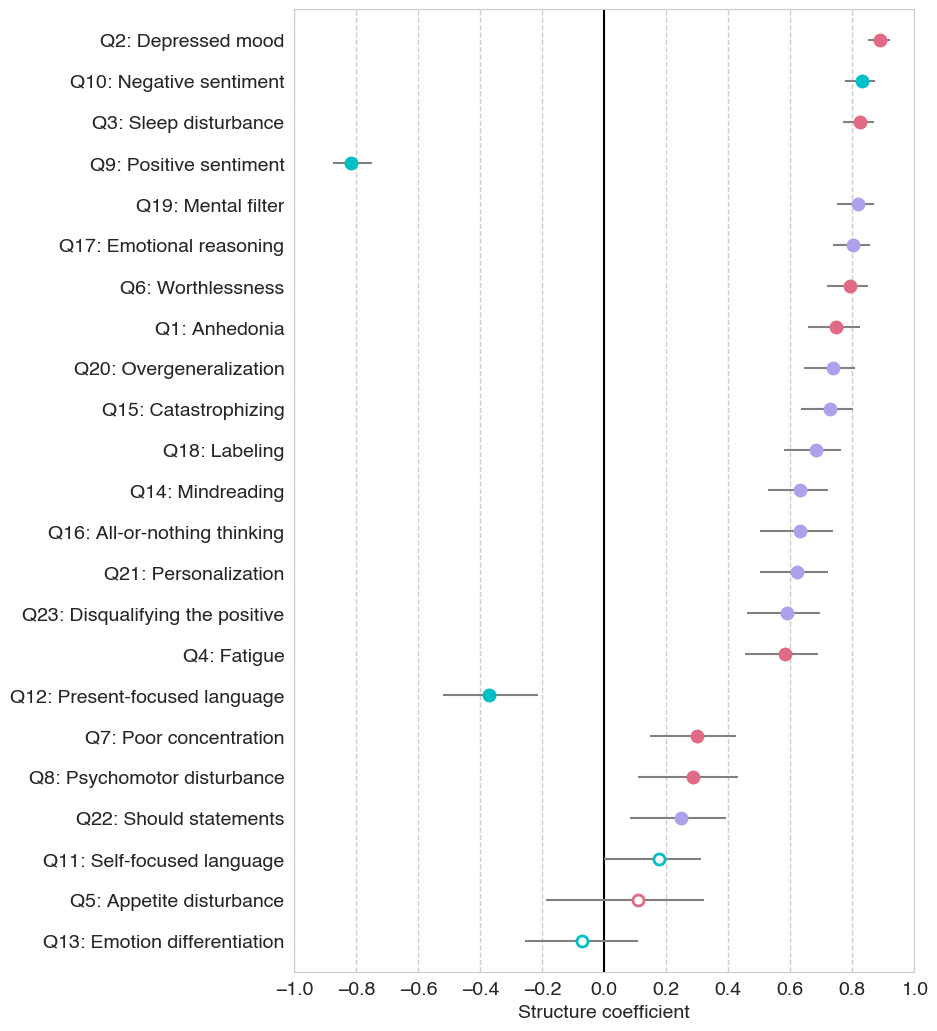

Test all:

Q2: Depressed mood; r = 0.89, 95% CI = 0.85 to 0.92, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q10: Negative sentiment; r = 0.83, 95% CI = 0.78 to 0.87, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q3: Sleep disturbance; r = 0.82, 95% CI = 0.77 to 0.87, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q9: Positive sentiment; r = -0.82, 95% CI = -0.87 to -0.75, p-val = 2.0E-04 (0.0002), FDR p-val = 2.7E-04 (0.0003)
Q19: Mental filter; r = 0.82, 95% CI = 0.75 to 0.87, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q17: Emotional reasoning; r = 0.80, 95% CI = 0.74 to 0.86, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q6: Worthlessness; r = 0.79, 95% CI = 0.72 to 0.85, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q1: Anhedonia; r = 0.75, 95% CI = 0.66 to 0.82, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q20: Overgeneralization; r = 0.74, 95% CI = 0.65 to 0.81, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.000

In [11]:
for split in ["Test 1", "Test 2", "Test all"]:
    X = np.array(all_resp_df.iloc[:, all_mdl["Full"]["Q"]])
    Yhat = np.array(all_mdl["Full"]["Y_pred"])
    wh_te = np.array(all_df["split"] != "Training" if split == "Test all" else all_df["split"] == split)
    X_te = X[wh_te, :]
    X_te_scaled = all_mdl["Full"]["scaler"].transform(X_te)
    Yhat_te = Yhat[wh_te]
    
    rs = np.array([np.corrcoef(X_te_scaled[:,item], Yhat_te)[0,1] for item in range(X.shape[1])])

    boot_n = 10000
    boot_ci = 0.95
    boot_rs = np.full([X.shape[1], boot_n], np.nan)
    np.random.seed(42)
    for boot_i in range(boot_n):
        boot_idx = np.random.choice(len(Yhat_te), len(Yhat_te), replace=True)
        boot_rs[:, boot_i] = np.array([np.corrcoef(X_te_scaled[boot_idx,item], Yhat_te[boot_idx])[0,1] for item in range(X.shape[1])])
    boot_rs[np.isnan(boot_rs)] = 0
    boot_rs_ci = np.sort(boot_rs, axis=1)[:, [int(boot_n*(1-boot_ci)/2)-1, int(boot_n*(1+boot_ci)/2)-1]]
    boot_rs_p = (np.sum(0 < boot_rs, axis=1) + 1) / (boot_n + 1)
    boot_rs_p = np.minimum(boot_rs_p, 1-boot_rs_p) * 2
    boot_rs_p_fdr = false_discovery_control(boot_rs_p)

    x = np.array(Q_desc)
    y = rs
    g = np.array([0]*8 + [1]*5 + [2]*10)
    idx = np.argsort(abs(y))
    yerr = boot_rs_ci
    
    plt.figure(figsize=(8, 12.5))
    sns.set_style("whitegrid", {"font.sans-serif": "Helvetica"})
    plt.grid(True, linestyle="--", linewidth=1, axis='x')
    plt.axvline(0, color='black')
    plt.errorbar(x=y[idx], y=x[idx], fmt="none", xerr=abs(y[:,np.newaxis]-yerr)[idx,:].T, color="gray")
    sns.pointplot(x=y[idx], y=None)
    for i in range(len(x)):
        c = ["#E16A86", "#00BFC6", "#ACA2EC"][g[idx][i]]
        fc = 'white' if boot_rs_p[idx][i] >= 0.05 else c
        mk, sz = ("D", 50) if (boot_rs_p_fdr[idx][i] >= 0.05) & (boot_rs_p[idx][i] < 0.05) else ("o", 50*4/np.pi)
        plt.scatter(y[idx][i], x[idx][i], color=c, edgecolor=c, linewidth=2, facecolor=fc, marker=mk, s=sz, zorder=3)
    plt.xlim([-1, 1])
    plt.ylim([-0.75, len(x)-0.25])
    plt.xlabel("Structure coefficient", fontsize=14)
    plt.xticks(np.arange(-1, 1+0.2, 0.2), fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_struct_coef_{split.replace(" ", "_")}.pdf"), bbox_inches='tight')
    plt.show()
    print(f"{split}:\n") 
    print("\n".join([f"{x_each}; r = {y_each:.2f}, 95% CI = {ci_each[0]:.2f} to {ci_each[1]:.2f}, p-val = {p_each:.1E} ({p_each:.4f}), FDR p-val = {p_fdr_each:.1E} ({p_fdr_each:.4f})"
                     for x_each, y_each, ci_each, p_each, p_fdr_each in zip(x[idx], y[idx], boot_rs_ci[idx,:], boot_rs_p[idx], boot_rs_p_fdr[idx])][::-1]))

In [12]:
X = np.array(all_resp_df.iloc[:, all_mdl["Full"]["Q"]])
Y = np.array(all_df["Depression_severity"])
wh_tr = np.array(all_df["split"] == "Training")
X_tr = X[wh_tr, :]
X_tr_scaled = StandardScaler().fit_transform(X_tr)
Y_tr = Y[wh_tr]

boot_n = 10000
boot_ci = 0.95
boot_coef = np.full([X.shape[1], boot_n], np.nan)
np.random.seed(42)
for boot_i in range(boot_n):
    boot_idx = np.random.choice(len(Y_tr), len(Y_tr), replace=True)
    boot_model = LinearRegression()
    boot_model.fit(X_tr_scaled[boot_idx, :], Y_tr[boot_idx])
    boot_coef[:, boot_i] = boot_model.coef_
boot_coef_ci = np.sort(boot_coef, axis=1)[:, [int(boot_n*(1-boot_ci)/2)-1, int(boot_n*(1+boot_ci)/2)-1]]
boot_coef_p = (np.sum(0 < boot_coef, axis=1) + 1) / (boot_n + 1)
boot_coef_p = np.minimum(boot_coef_p, 1-boot_coef_p) * 2
boot_coef_p_fdr = false_discovery_control(boot_coef_p)

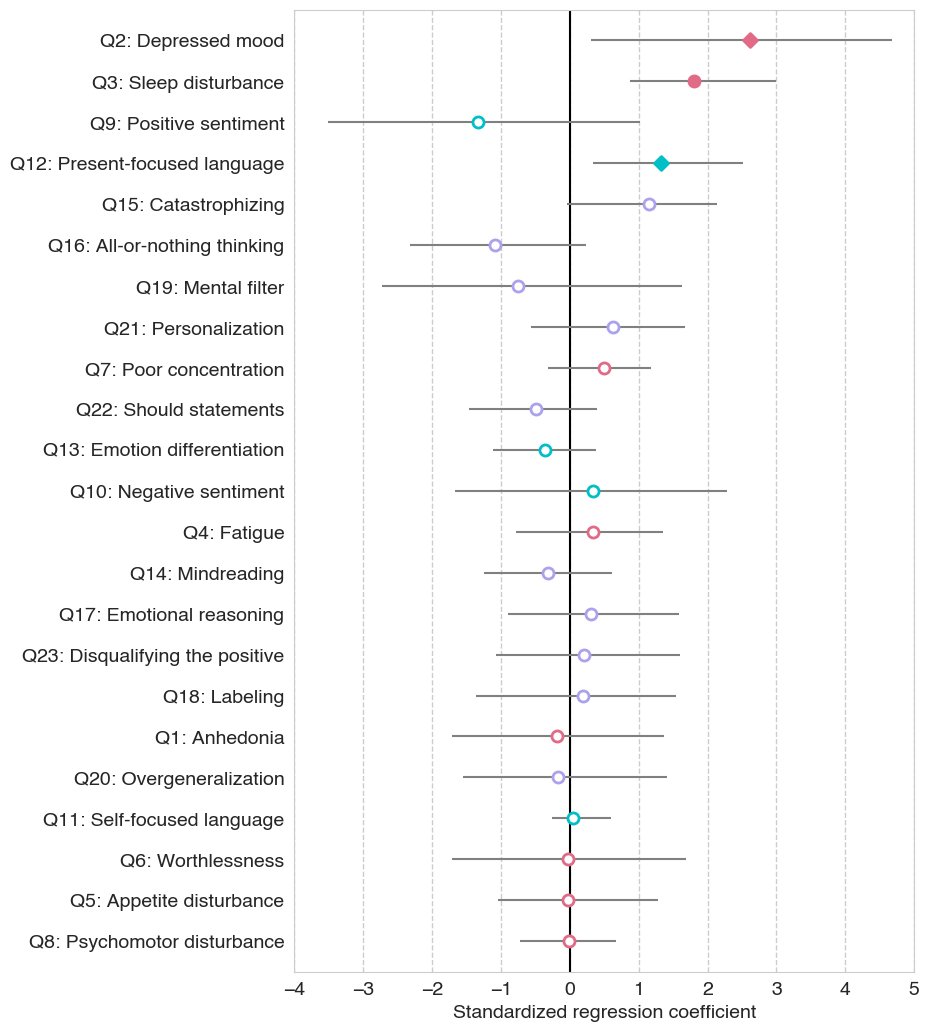

Q2: Depressed mood; β = 2.61, 95% CI = 0.30 to 4.68, p-val = 2.6E-02 (0.0256), FDR p-val = 2.0E-01 (0.1962)
Q3: Sleep disturbance; β = 1.81, 95% CI = 0.88 to 2.99, p-val = 2.0E-04 (0.0002), FDR p-val = 4.6E-03 (0.0046)
Q9: Positive sentiment; β = -1.33, 95% CI = -3.52 to 1.02, p-val = 2.4E-01 (0.2380), FDR p-val = 7.4E-01 (0.7411)
Q12: Present-focused language; β = 1.32, 95% CI = 0.34 to 2.52, p-val = 1.0E-02 (0.0100), FDR p-val = 1.1E-01 (0.1150)
Q15: Catastrophizing; β = 1.15, 95% CI = -0.04 to 2.14, p-val = 5.7E-02 (0.0570), FDR p-val = 3.3E-01 (0.3277)
Q16: All-or-nothing thinking; β = -1.08, 95% CI = -2.33 to 0.23, p-val = 1.2E-01 (0.1206), FDR p-val = 5.5E-01 (0.5547)
Q19: Mental filter; β = -0.75, 95% CI = -2.72 to 1.63, p-val = 6.4E-01 (0.6391), FDR p-val = 9.9E-01 (0.9949)
Q21: Personalization; β = 0.62, 95% CI = -0.56 to 1.67, p-val = 3.1E-01 (0.3074), FDR p-val = 7.6E-01 (0.7640)
Q7: Poor concentration; β = 0.49, 95% CI = -0.32 to 1.18, p-val = 2.0E-01 (0.1964), FDR p-val = 

In [13]:
x = np.array(Q_desc)
y = all_mdl["Full"]["model"].coef_
g = np.array([0]*8 + [1]*5 + [2]*10)
idx = np.argsort(abs(y))
yerr = boot_coef_ci

plt.figure(figsize=(8, 12.5))
sns.set_style("whitegrid", {"font.sans-serif": "Helvetica"})
plt.grid(True, linestyle="--", linewidth=1, axis='x')
plt.axvline(0, color='black')
plt.errorbar(x=y[idx], y=x[idx], fmt="none", xerr=abs(y[:,np.newaxis]-yerr)[idx,:].T, color="gray")
sns.pointplot(x=y[idx], y=None)
for i in range(len(x)):
    c = ["#E16A86", "#00BFC6", "#ACA2EC"][g[idx][i]]
    fc = 'white' if boot_coef_p[idx][i] >= 0.05 else c
    mk, sz = ("D", 50) if (boot_coef_p_fdr[idx][i] >= 0.05) & (boot_coef_p[idx][i] < 0.05) else ("o", 50*4/np.pi)
    plt.scatter(y[idx][i], x[idx][i], color=c, edgecolor=c, linewidth=2, facecolor=fc, marker=mk, s=sz, zorder=3)
plt.xlim([-4, 5])
plt.ylim([-0.75, len(x)-0.25])
plt.xlabel("Standardized regression coefficient", fontsize=14)
plt.xticks(np.arange(-4, 5+1, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(result_dir, "AIDA_coef.pdf"), bbox_inches='tight')
plt.show()
print("\n".join([f"{x_each}; β = {y_each:.2f}, 95% CI = {ci_each[0]:.2f} to {ci_each[1]:.2f}, p-val = {p_each:.1E} ({p_each:.4f}), FDR p-val = {p_fdr_each:.1E} ({p_fdr_each:.4f})"
                 for x_each, y_each, ci_each, p_each, p_fdr_each in zip(x[idx], y[idx], boot_coef_ci[idx,:], boot_coef_p[idx], boot_coef_p_fdr[idx])][::-1]))

In [14]:
X = np.array(all_resp_df.iloc[:, all_mdl["Full"]["Q"]])
Y = np.array(all_df["Depression_severity"])
wh_tr = np.array(all_df["split"] == "Training")
X_tr = X[wh_tr, :]
X_tr_scaled = StandardScaler().fit_transform(X_tr)
Y_tr = Y[wh_tr]

univ_coef = np.full(X.shape[1], np.nan)
for f in range(X.shape[1]):
    univ_model = LinearRegression()
    univ_model.fit(X_tr_scaled[:, f].reshape(-1, 1), Y_tr)
    univ_coef[f] = univ_model.coef_[0]

bootuniv_n = 10000
bootuniv_ci = 0.95
bootuniv_coef = np.full([X.shape[1], bootuniv_n], np.nan)
np.random.seed(42)
for bootuniv_i in range(bootuniv_n):
    bootuniv_idx = np.random.choice(len(Y_tr), len(Y_tr), replace=True)
    for f in range(X.shape[1]):
        bootuniv_model = LinearRegression()
        bootuniv_model.fit(X_tr_scaled[bootuniv_idx, f].reshape(-1, 1), Y_tr[bootuniv_idx])
        bootuniv_coef[f, bootuniv_i] = bootuniv_model.coef_[0]
bootuniv_coef_ci = np.sort(bootuniv_coef, axis=1)[:, [int(bootuniv_n*(1-bootuniv_ci)/2)-1, int(bootuniv_n*(1+bootuniv_ci)/2)-1]]
bootuniv_coef_p = (np.sum(0 < bootuniv_coef, axis=1) + 1) / (bootuniv_n + 1)
bootuniv_coef_p = np.minimum(bootuniv_coef_p, 1-bootuniv_coef_p) * 2
bootuniv_coef_p_fdr = false_discovery_control(bootuniv_coef_p)

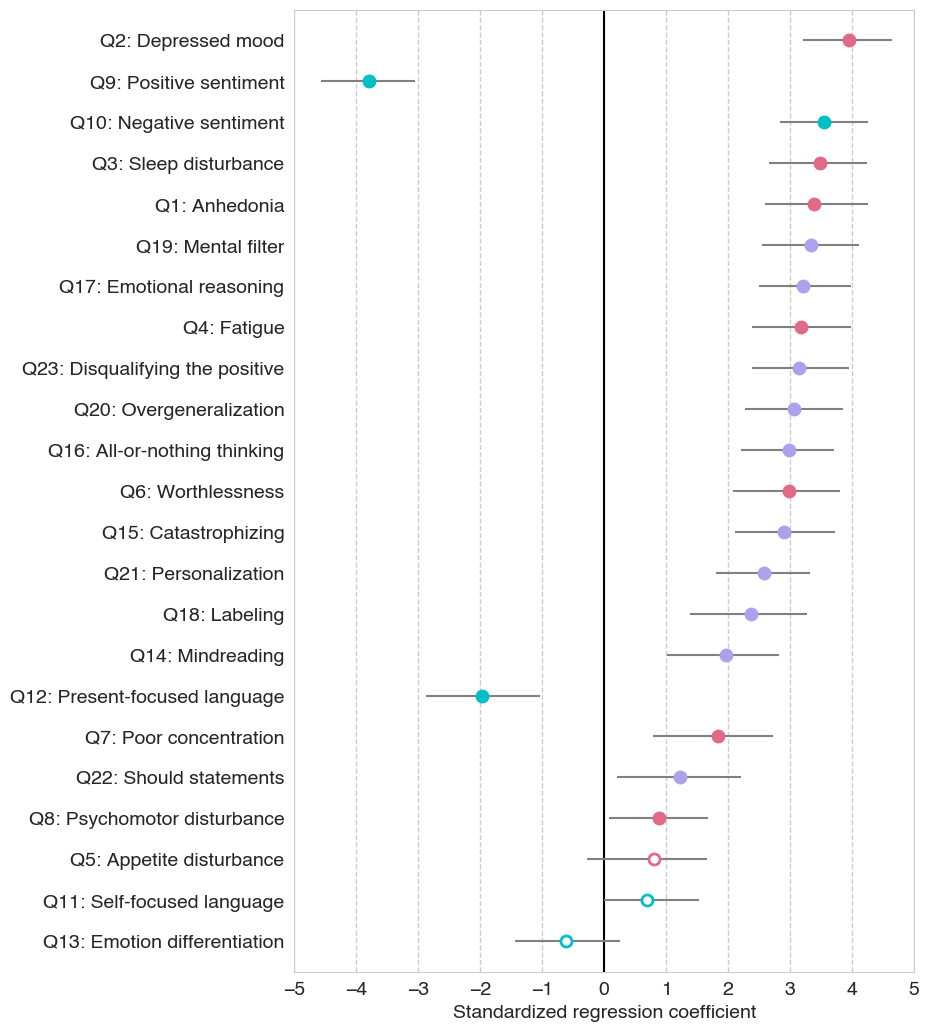

Q2: Depressed mood; β = 3.94, 95% CI, 3.21 to 4.64, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q9: Positive sentiment; β = -3.80, 95% CI, -4.57 to -3.06, p-val = 2.0E-04 (0.0002), FDR p-val = 2.7E-04 (0.0003)
Q10: Negative sentiment; β = 3.54, 95% CI, 2.83 to 4.25, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q3: Sleep disturbance; β = 3.48, 95% CI, 2.66 to 4.24, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q1: Anhedonia; β = 3.38, 95% CI, 2.59 to 4.25, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q19: Mental filter; β = 3.33, 95% CI, 2.55 to 4.11, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q17: Emotional reasoning; β = 3.21, 95% CI, 2.49 to 3.98, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q4: Fatigue; β = 3.18, 95% CI, 2.38 to 3.98, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q23: Disqualifying the positive; β = 3.14, 95% CI, 2.38 to 3.94, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q20: Overgenera

In [15]:
x = np.array(Q_desc)
y = univ_coef
g = np.array([0]*8 + [1]*5 + [2]*10)
idx = np.argsort(abs(y))
yerr = bootuniv_coef_ci

plt.figure(figsize=(8, 12.5))
sns.set_style("whitegrid", {"font.sans-serif": "Helvetica"})
plt.grid(True, linestyle="--", linewidth=1, axis='x')
plt.axvline(0, color='black')
plt.errorbar(x=y[idx], y=x[idx], fmt="none", xerr=abs(y[:,np.newaxis]-yerr)[idx,:].T, color="gray")
sns.pointplot(x=y[idx], y=None)
for i in range(len(x)):
    c = ["#E16A86", "#00BFC6", "#ACA2EC"][g[idx][i]]
    fc = 'white' if bootuniv_coef_p[idx][i] >= 0.05 else c
    mk, sz = ("D", 50) if (bootuniv_coef_p_fdr[idx][i] >= 0.05) & (bootuniv_coef_p[idx][i] < 0.05) else ("o", 50*4/np.pi)
    plt.scatter(y[idx][i], x[idx][i], color=c, edgecolor=c, linewidth=2, facecolor=fc, marker=mk, s=sz, zorder=3)
plt.xlim([-5, 5])
plt.ylim([-0.75, len(x)-0.25])
plt.xlabel("Standardized regression coefficient", fontsize=14)
plt.xticks(np.arange(-5, 6), fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(result_dir, "AIDA_coef_univ.pdf"), bbox_inches='tight')
plt.show()
print("\n".join([f"{x_each}; β = {y_each:.2f}, 95% CI, {ci_each[0]:.2f} to {ci_each[1]:.2f}, p-val = {p_each:.1E} ({p_each:.4f}), FDR p-val = {p_fdr_each:.1E} ({p_fdr_each:.4f})"
                 for x_each, y_each, ci_each, p_each, p_fdr_each in zip(x[idx], y[idx], bootuniv_coef_ci[idx,:], bootuniv_coef_p[idx], bootuniv_coef_p_fdr[idx])][::-1]))

In [16]:
X = np.array(all_resp_df.iloc[:, all_mdl["Full"]["Q"]])
Y = np.array(all_df["Depression_severity"])
Y_pred = all_mdl["Full"]["Y_pred"]
wh_te = np.array(all_df["split"] != "Training")
X_te = X[wh_te, :]
X_te_scaled = all_mdl["Full"]["scaler"].transform(X_te)
Y_te = Y[wh_te]
Y_te_pred = Y_pred[wh_te]

ae = np.abs(Y_te - Y_te_pred)
ae_les = np.full([len(Y_te), X.shape[1]], np.nan)
for f in range(X.shape[1]):
    Y_te_pred_les = all_mdl["Full"]["model"].predict(X_te_scaled * (np.arange(X.shape[1]) != f))
    ae_les[:, f] = np.abs(Y_te - Y_te_pred_les)
dae = ae_les - ae[:, np.newaxis]
dmae = np.mean(dae, axis=0)

bootles_n = 10000
bootles_ci = 0.95
bootles_dmae = np.full([X.shape[1], bootles_n], np.nan)
np.random.seed(42)
for bootles_i in range(bootles_n):
    bootles_idx = np.random.choice(len(Y_te), len(Y_te), replace=True)
    bootles_dmae[:, bootles_i] = np.mean(dae[bootles_idx, :], axis=0)
bootles_dmae_ci = np.sort(bootles_dmae, axis=1)[:, [int(bootles_n*(1-bootles_ci)/2)-1, int(bootles_n*(1+bootles_ci)/2)-1]]
bootles_dmae_p = (np.sum(0 < bootles_dmae, axis=1) + 1) / (bootles_n + 1)
bootles_dmae_p = np.minimum(bootles_dmae_p, 1-bootles_dmae_p) * 2
bootles_dmae_p_fdr = false_discovery_control(bootles_dmae_p)

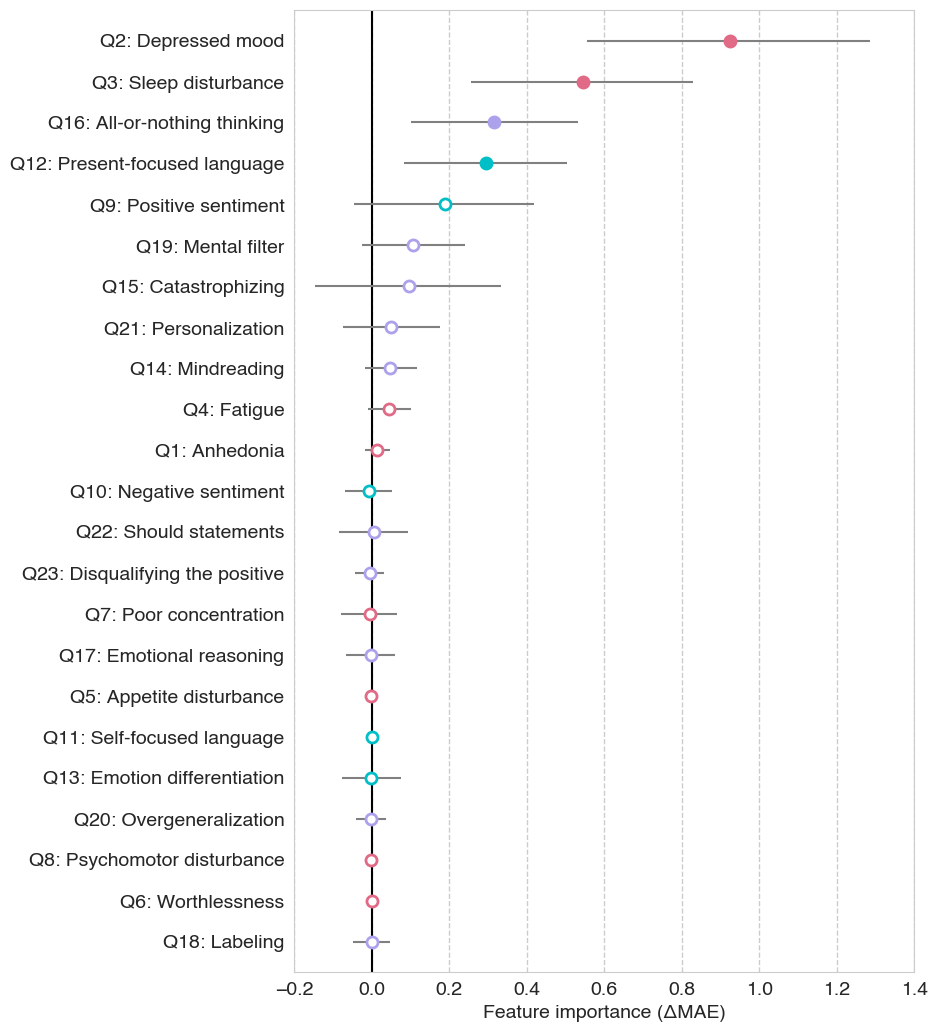

Q2: Depressed mood; β = 0.92, 95% CI, 0.56 to 1.29, p-val = 0.0E+00 (0.0000), FDR p-val = 0.0E+00 (0.0000)
Q3: Sleep disturbance; β = 0.55, 95% CI, 0.26 to 0.83, p-val = 2.0E-04 (0.0002), FDR p-val = 2.3E-03 (0.0023)
Q16: All-or-nothing thinking; β = 0.32, 95% CI, 0.10 to 0.53, p-val = 3.0E-03 (0.0030), FDR p-val = 2.3E-02 (0.0230)
Q12: Present-focused language; β = 0.30, 95% CI, 0.08 to 0.50, p-val = 6.4E-03 (0.0064), FDR p-val = 3.7E-02 (0.0368)
Q9: Positive sentiment; β = 0.19, 95% CI, -0.05 to 0.42, p-val = 1.1E-01 (0.1148), FDR p-val = 3.3E-01 (0.3300)
Q19: Mental filter; β = 0.11, 95% CI, -0.03 to 0.24, p-val = 1.1E-01 (0.1126), FDR p-val = 3.3E-01 (0.3300)
Q15: Catastrophizing; β = 0.10, 95% CI, -0.15 to 0.33, p-val = 4.4E-01 (0.4450), FDR p-val = 7.9E-01 (0.7872)
Q21: Personalization; β = 0.05, 95% CI, -0.08 to 0.18, p-val = 4.4E-01 (0.4448), FDR p-val = 7.9E-01 (0.7872)
Q14: Mindreading; β = 0.05, 95% CI, -0.02 to 0.12, p-val = 1.6E-01 (0.1558), FDR p-val = 4.0E-01 (0.3981)
Q4

In [17]:
x = np.array(Q_desc)
y = dmae
g = np.array([0]*8 + [1]*5 + [2]*10)
idx = np.argsort(abs(y))
yerr = bootles_dmae_ci

plt.figure(figsize=(8, 12.5))
sns.set_style("whitegrid", {"font.sans-serif": "Helvetica"})
plt.grid(True, linestyle="--", linewidth=1, axis='x')
plt.axvline(0, color='black')
plt.errorbar(x=y[idx], y=x[idx], fmt="none", xerr=abs(y[:,np.newaxis]-yerr)[idx,:].T, color="gray")
sns.pointplot(x=y[idx], y=None)
for i in range(len(x)):
    c = ["#E16A86", "#00BFC6", "#ACA2EC"][g[idx][i]]
    fc = 'white' if bootles_dmae_p[idx][i] >= 0.05 else c
    mk, sz = ("D", 50) if (bootles_dmae_p_fdr[idx][i] >= 0.05) & (bootles_dmae_p[idx][i] < 0.05) else ("o", 50*4/np.pi)
    plt.scatter(y[idx][i], x[idx][i], color=c, edgecolor=c, linewidth=2, facecolor=fc, marker=mk, s=sz, zorder=3)
plt.xlim([-0.2, 1.4])
plt.ylim([-0.75, len(x)-0.25])
plt.xlabel("Feature importance (ΔMAE)", fontsize=14)
plt.xticks(np.arange(-0.2, 1.6, 0.2), fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(result_dir, "AIDA_dMAE.pdf"), bbox_inches='tight')
plt.show()
print("\n".join([f"{x_each}; β = {y_each:.2f}, 95% CI, {ci_each[0]:.2f} to {ci_each[1]:.2f}, p-val = {p_each:.1E} ({p_each:.4f}), FDR p-val = {p_fdr_each:.1E} ({p_fdr_each:.4f})"
                 for x_each, y_each, ci_each, p_each, p_fdr_each in zip(x[idx], y[idx], bootles_dmae_ci[idx,:], bootles_dmae_p[idx], bootles_dmae_p_fdr[idx])][::-1]))